# Initial setup of the imports and main variables

In [18]:
from pathlib import Path
from typing import Any, Dict, List, Tuple
from dataclasses import dataclass

from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm

from ml_carbucks import DATA_DIR
from ml_carbucks.adapters.EfficientDetAdapter import EfficientDetAdapter
from ml_carbucks.adapters.FasterRcnnAdapter import FasterRcnnAdapter
from ml_carbucks.adapters.UltralyticsAdapter import RtdetrUltralyticsAdapter, YoloUltralyticsAdapter
from ml_carbucks.utils.logger import setup_logger
from ml_carbucks.utils.preprocessing import create_clean_loader
from ml_carbucks.utils.postprocessing import process_evaluation_results
from ml_carbucks.adapters.BaseDetectionAdapter import BaseDetectionAdapter

logger = setup_logger("adapter_fusion")


classes=["scratch", "dent", "crack"]

adapters=[
    YoloUltralyticsAdapter(
        classes=["scratch", "dent", "crack"],
        **{
            "img_size": 384,
            "batch_size": 32,
            "epochs": 27,
            "lr": 0.0015465639515144544,
            "momentum": 0.3628781599889685,
            "weight_decay": 0.0013127041660177367,
            "optimizer": "NAdam",
            "verbose": False,
        },
        weights="/home/bachelor/ml-carbucks/results/ensemble_demos/trial_4_YoloUltralyticsAdaptermodel.pt",
    ),
    RtdetrUltralyticsAdapter(
        classes=["scratch", "dent", "crack"],
        **{
            "img_size": 384,
            "batch_size": 16,
            "epochs": 10,
            "lr": 0.0001141043015859849,
            "momentum": 0.424704619626319,
            "weight_decay": 0.00012292547851740234,
            "optimizer": "AdamW",
        },
        weights="/home/bachelor/ml-carbucks/results/ensemble_demos/trial_4_RtdetrUltralyticsAdaptermodel.pt",
    ),
    # FasterRcnnAdapter(
    #     classes=["scratch", "dent", "crack"],
    #     **{
    #         "img_size": 384,
    #         "batch_size": 8,
    #         "epochs": 30,
    #         "lr_backbone": 2.6373762637681257e-05,
    #         "lr_head": 0.0011244046084737927,
    #         "weight_decay_backbone": 0.000796017512818448,
    #         "weight_decay_head": 0.0005747409908715994,
    #     },
    #     weights="/home/bachelor/ml-carbucks/results/ensemble_demos/FasterRcnnAdaptermodel.pth",
    # ),
    EfficientDetAdapter(
        classes=["scratch", "dent", "crack"],
        **{
            "img_size": 384,
            "batch_size": 8,
            "epochs": 26,
            "optimizer": "momentum",
            "lr": 0.003459928723120903,
            "weight_decay": 0.0001302610542371722,
        },
        weights="/home/bachelor/ml-carbucks/results/ensemble_demos/trial_4_EfficientDetAdaptermodel.pth",
    ),
]

train_datasets = [
    (
        DATA_DIR / "car_dd_testing" / "images" / "train",
        DATA_DIR / "car_dd_testing" / "instances_train_curated.json",
    )
]

val_datasets: List[Tuple[str | Path, str | Path]] = [
    (
        DATA_DIR / "car_dd_testing" / "images" / "val",
        DATA_DIR / "car_dd_testing" / "instances_val_curated.json",
    )
]

# Script that generates evaluates each adapter and returns a list of list of predictions for each adapter
This is useful for debugging and developing later in the code

In [19]:
@dataclass
class EnsembleModel:
    classes: List[str]
    adapters: List[BaseDetectionAdapter]

    def setup(self) -> "EnsembleModel":
        for adapter in self.adapters:
            adapter.setup()
        return self

    def evaluate_adapters_by_evaluation_from_dataset(
        self, datasets: List[Tuple[str | Path, str | Path]]
    ) -> List[dict]:
        metrics = []
        for adapter in self.adapters:
            adapter_metrics = adapter.evaluate(datasets)
            metrics.append(adapter_metrics)
        return metrics

    def evaluate_adapters_by_predict_from_dataset(
        self, datasets: List[Tuple[str | Path, str | Path]]
    ) -> List[dict]:

        metrics = [MeanAveragePrecision() for _ in self.adapters]
        loader = create_clean_loader(
            datasets, shuffle=False, transforms=None, batch_size=8
        )
        results = []
        for adapter_idx, adapter in enumerate(self.adapters):
            logger.info(f"Evaluating adapter: {adapter.__class__.__name__}")
            for images, targets in tqdm(loader):
                predictions = adapter.predict(images)

                metrics[adapter_idx].update(predictions, targets)  # type: ignore

            metric = metrics[adapter_idx].compute()
            results.append(metric)

        final_results = [process_evaluation_results(metric) for metric in results]
        return final_results

    def evaluate(self, datasets: List[Tuple[str | Path, str | Path]]):
    # -> Dict[str, Any]:
        loader = create_clean_loader(
            datasets, shuffle=False, transforms=None, batch_size=8
        )

        adapters_predictions = {
            adapter.__class__.__name__: [] for adapter in self.adapters
        }
        adapters_predictions = [ [] for _ in self.adapters]

        ground_truths = []

        logger.info("Collecting adapter predictions...")    
        for images, targets in tqdm(loader):

            for adapter_idx, adapter in enumerate(self.adapters):
                preds = adapter.predict(images)
                adapters_predictions[adapter_idx].extend(preds)

            ground_truths.extend({
                "boxes": target["boxes"],
                "labels": target["labels"],
            } for target in targets)

        logger.info("Adapter predictions collected.")

        for adapter_idx, adapter in enumerate(self.adapters):
            logger.info(f"Evaluating adapter: {adapter.__class__.__name__}")
            metric = MeanAveragePrecision()
            metric.update(adapters_predictions[adapter_idx], ground_truths)  # type: ignore
            result = metric.compute()
            processed_result = process_evaluation_results(result)
            logger.info(f"Results for {adapter.__class__.__name__}: {processed_result}")

        return adapters_predictions, ground_truths

ensemble_model = EnsembleModel(
    classes=classes,
    adapters=adapters,
).setup()

adap_preds, gts = ensemble_model.evaluate(val_datasets)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
INFO adapter_fusion 19:58:25 | Collecting adapter predictions...


100%|██████████| 102/102 [00:23<00:00,  4.26it/s]

INFO adapter_fusion 19:58:49 | Adapter predictions collected.
INFO adapter_fusion 19:58:49 | Evaluating adapter: YoloUltralyticsAdapter


INFO adapter_fusion 19:58:49 | Results for YoloUltralyticsAdapter: {'map_50': 0.3114479184150696, 'map_50_95': 0.1649264544248581, 'map_75': 0.1527780294418335, 'classes': [1, 2, 3]}
INFO adapter_fusion 19:58:49 | Evaluating adapter: RtdetrUltralyticsAdapter
INFO adapter_fusion 19:58:49 | Results for RtdetrUltralyticsAdapter: {'map_50': 0.44884592294692993, 'map_50_95': 0.2507704794406891, 'map_75': 0.24307547509670258, 'classes': [1, 2, 3]}
INFO adapter_fusion 19:58:49 | Evaluating adapter: EfficientDetAdapter
INFO adapter_fusion 19:58:49 | Results for EfficientDetAdapter: {'map_50': 0.3560166358947754, 'map_50_95': 0.16611579060554504, 'map_75': 0.13654088973999023, 'classes': [1, 2, 3]}


In [ ]:
import pickle as pkl
pkl.dump( (adap_preds, gts), open("ignore_temp_ensemble_merging_artifact.pkl", "wb"))

# Actual debugging and ensmble results comparison

INFO adapter_fusion 22:32:08 | Applying NMS fusion strategy...
INFO adapter_fusion 22:32:08 | Adapters: 3 , Len: 810, GTs: 810
INFO adapter_fusion 22:32:08 | Final fused results: {'map_50': 0.46973365545272827, 'map_50_95': 0.26223716139793396, 'map_75': 0.2591218054294586, 'classes': [1, 2, 3]}
INFO adapter_fusion 22:32:08 | Displaying 2 images after skipping 1 images.
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


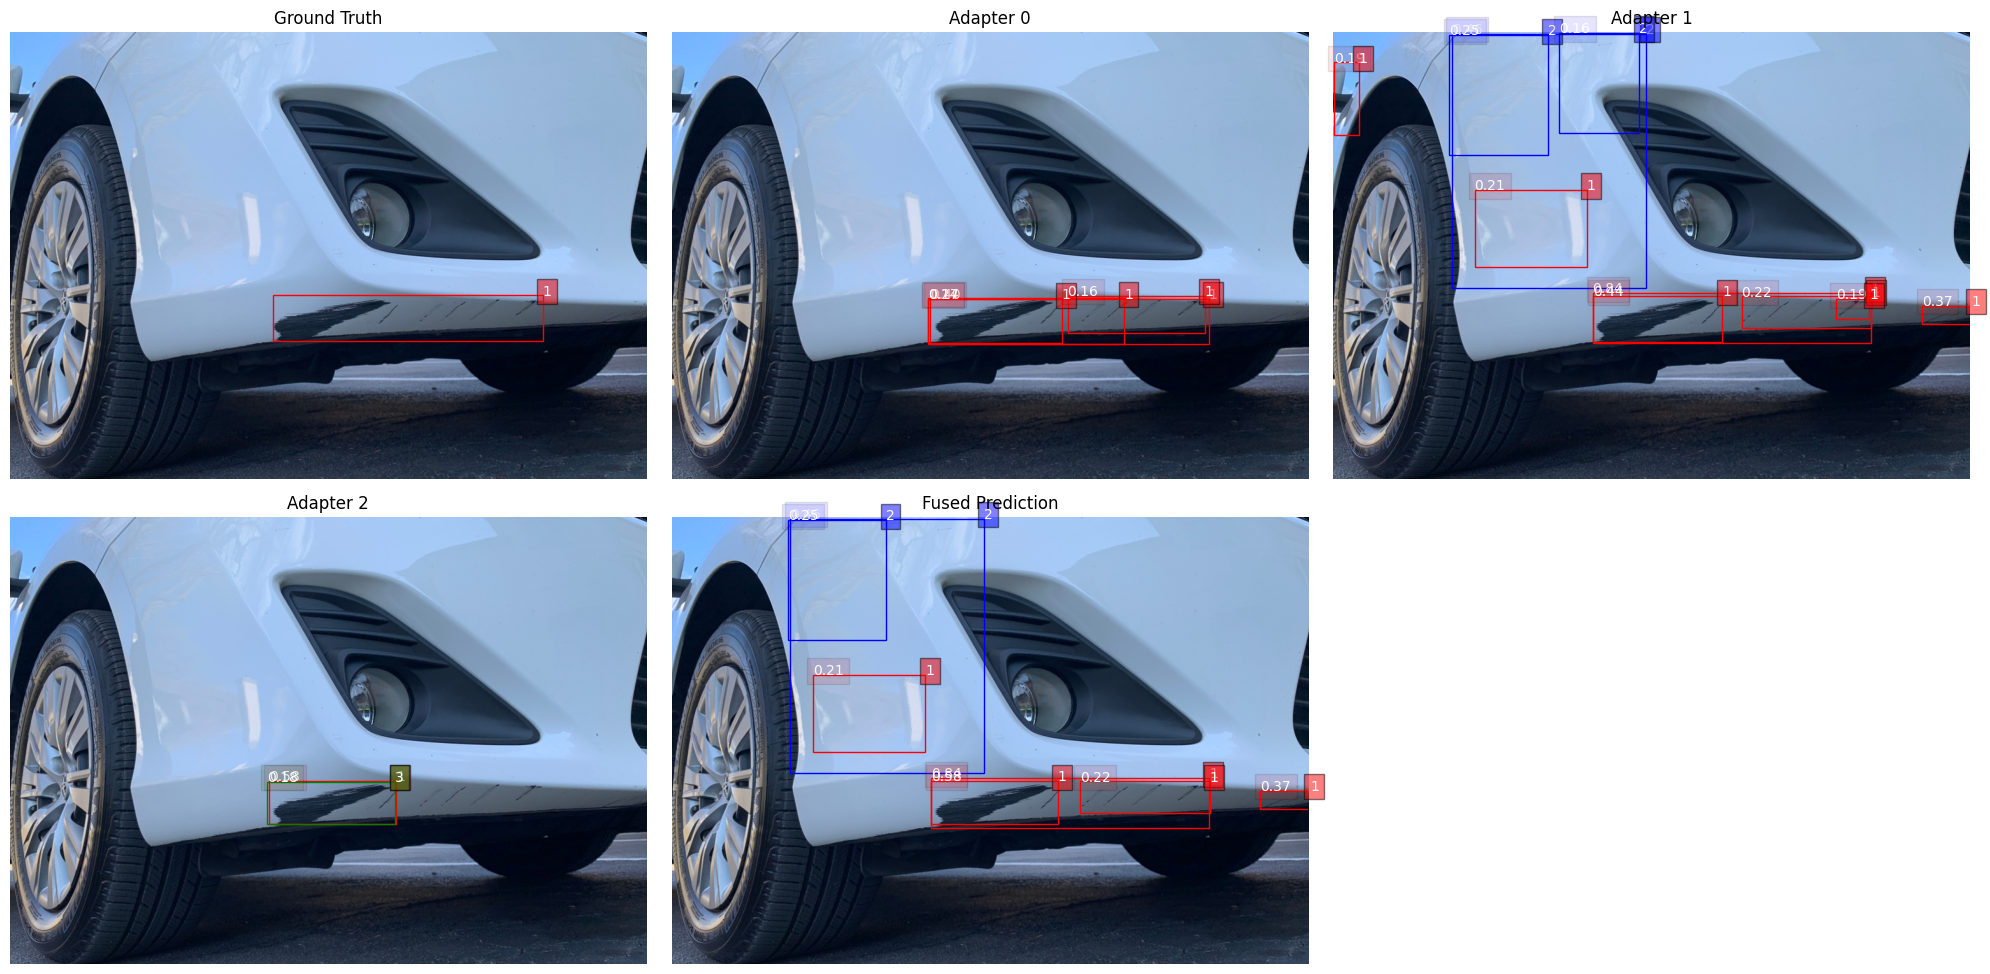

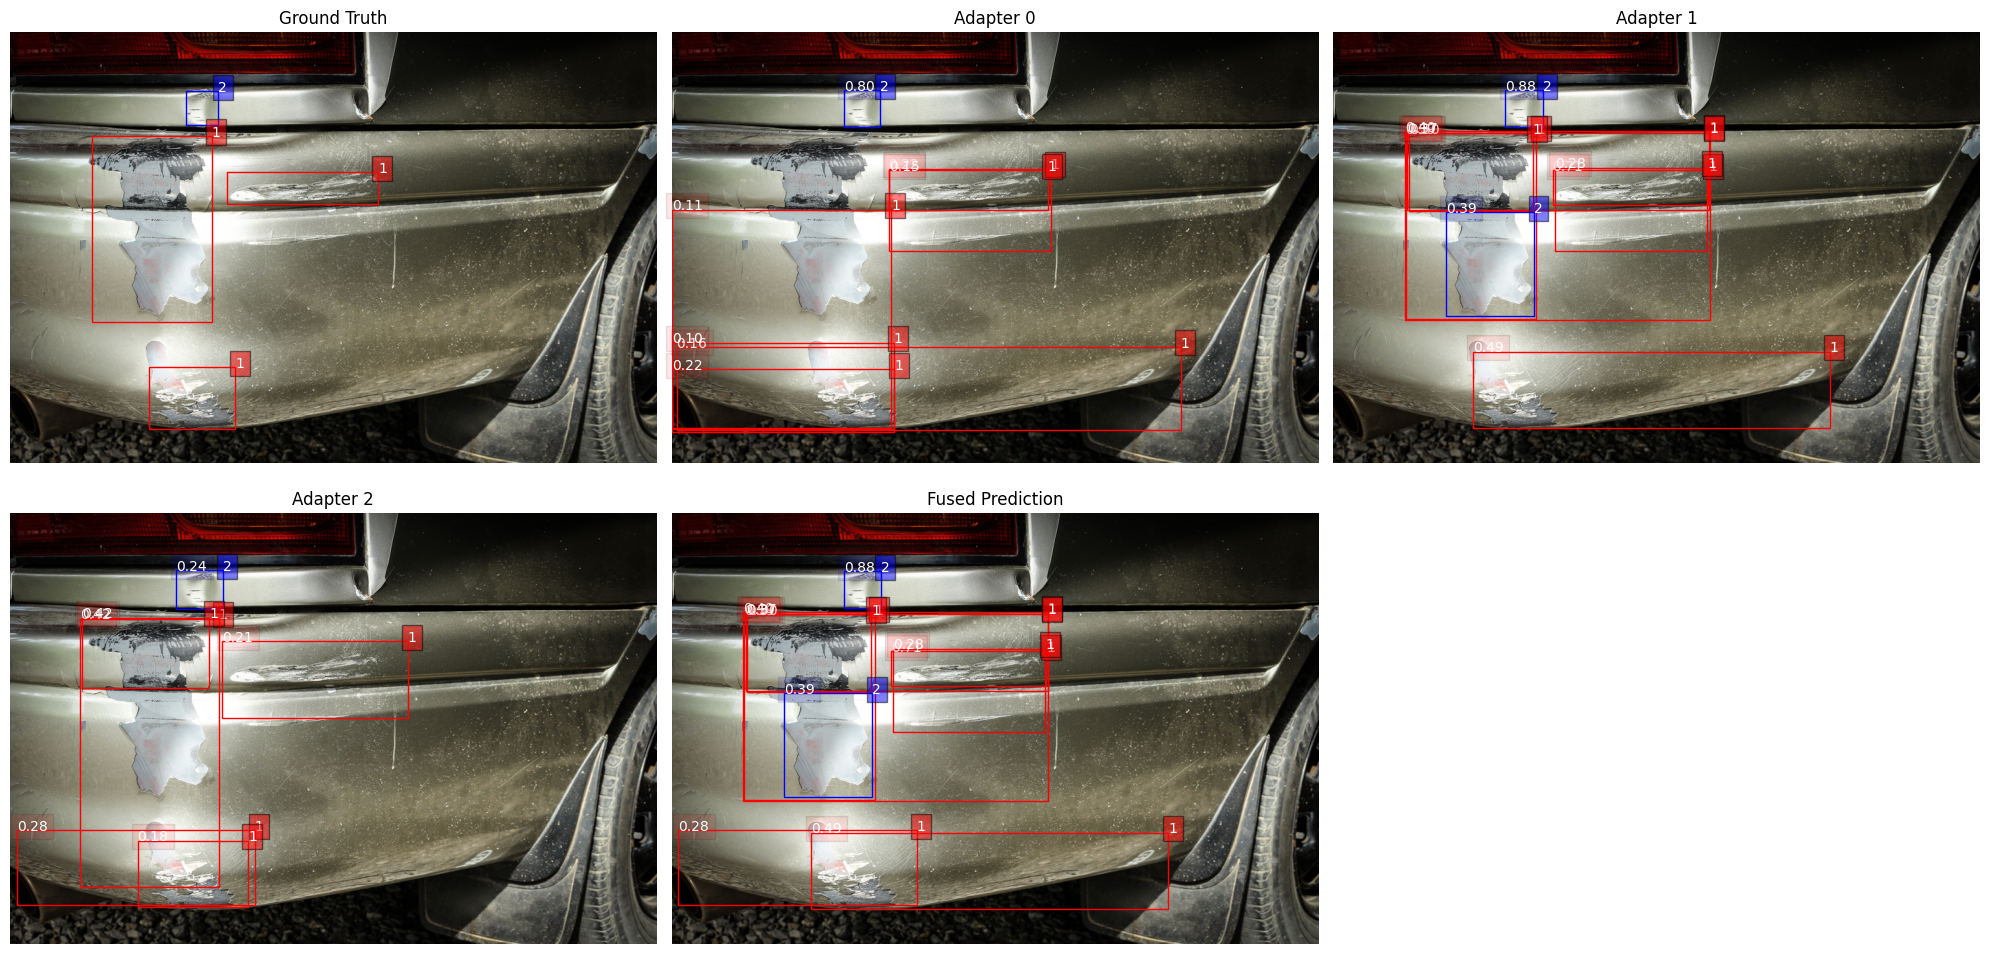

In [171]:
from copy import deepcopy
import random
from typing import Literal, Optional

import torch
from torch import Tensor
from torchvision.ops import nms
import pickle as pkl
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from ml_carbucks.adapters.BaseDetectionAdapter import ADAPTER_PREDICTION
from ml_carbucks.utils.postprocessing import process_evaluation_results
from ml_carbucks.utils.logger import setup_logger
from ml_carbucks.utils.preprocessing import create_clean_loader
from ml_carbucks import DATA_DIR
from typing import List, Tuple
import torch
from pathlib import Path
from ml_carbucks.utils.inference import plot_img_pred_subplots as psp


logger = setup_logger("adapter_fusion")
val_datasets: List[Tuple[str | Path, str | Path]] = [
    (
        DATA_DIR / "car_dd_testing" / "images" / "val",
        DATA_DIR / "car_dd_testing" / "instances_val_curated.json",
    )
]

adap_preds, gts = pkl.load(open("ignore_temp_ensemble_merging_artifact.pkl", "rb"))


def normalize_scores(
    preds_list: list[list[torch.Tensor]],
    method: Literal["minmax", "zscore"] = "minmax",
    trust: Optional[list[float]] = None,
) -> list[torch.Tensor]:
    if trust is None:
        trust = [1.0] * len(preds_list)
    normalized_all = []
    for preds, t in zip(preds_list, trust):
        flat_scores = torch.cat([p[:, 4] for p in preds], dim=0)
        s_min, s_max = flat_scores.min(), flat_scores.max()
        mean, std = flat_scores.mean(), flat_scores.std() + 1e-6
        normalized = deepcopy(preds)

        for p in normalized:
            if method == "minmax":
                p[:, 4] = (p[:, 4] - s_min) / (s_max - s_min + 1e-6)
            elif method == "zscore":
                p[:, 4] = (p[:, 4] - mean) / std
            else:
                raise ValueError(f"Unknown normalization method: {method}")
            p[:, 4] = p[:, 4] * t

        normalized_all.append(normalized)
    return normalized_all


def postprocess_prediction(
    boxes: Tensor,
    scores: Tensor,
    labels: Tensor,
    conf_threshold: float,
    iou_threshold: float,
    max_detections: int,
) -> ADAPTER_PREDICTION:
    

    device = boxes.device    
    boxes = boxes.to(device)
    scores = scores.to(device)
    labels = labels.to(device)


    if boxes.numel() == 0 or scores.numel() == 0 or labels.numel() == 0:
        return {"boxes": torch.empty((0, 4)), "scores": torch.empty((0,)), "labels": torch.empty((0,), dtype=torch.long)}


    if conf_threshold is not None and conf_threshold > 0:
        keep_mask = scores >= float(conf_threshold)
        if keep_mask.sum().item() == 0:
            return {"boxes": torch.empty((0, 4)), "scores": torch.empty((0,)), "labels": torch.empty((0,), dtype=torch.long)}
        boxes = boxes[keep_mask]
        scores = scores[keep_mask]
        labels = labels[keep_mask]

    
    if max_detections is None:
        max_detections = 0
    if not isinstance(max_detections, int):
        try:
            max_detections = int(max_detections)
        except Exception:
            raise ValueError("max_detections must be an integer or None")


    # If no NMS requested (iou out of (0,1) range), just select top-K by score
    if not (0.0 < float(iou_threshold) < 1.0):
        if max_detections <= 0:
            # return all (already on CPU)
            order = scores.argsort(descending=True)
        else:
            order = scores.argsort(descending=True)[: max_detections]
        return {
            "boxes": boxes[order].clone().detach(),
            "scores": scores[order].clone().detach(),
            "labels": labels[order].clone().detach().long(),
        }
    
    # Per-class NMS
    keep_indices_list = []
    unique_labels = torch.unique(labels)
    for cls in unique_labels:
        cls_mask = labels == cls
        if cls_mask.sum() == 0:
            continue
        cls_boxes = boxes[cls_mask]
        cls_scores = scores[cls_mask]
        # nms expects tensors on same device (we're on CPU), and returns indices relative to cls_boxes
        cls_keep = nms(cls_boxes, cls_scores, float(iou_threshold))
        if cls_keep.numel() == 0:
            continue
        # Map class-local indices back to global indices
        global_indices = torch.nonzero(cls_mask, as_tuple=False).squeeze(1)
        keep_indices_list.append(global_indices[cls_keep])


    if len(keep_indices_list) == 0:
        return {"boxes": torch.empty((0, 4)), "scores": torch.empty((0,)), "labels": torch.empty((0,), dtype=torch.long)}

    keep_indices = torch.cat(keep_indices_list)

    # Sort kept boxes by descending score and enforce max_detections
    sorted_by_score = scores[keep_indices].argsort(descending=True)
    if max_detections > 0:
        sorted_by_score = sorted_by_score[:max_detections]
    final_indices = keep_indices[sorted_by_score]

    final_boxes = boxes[final_indices].clone().detach()
    final_scores = scores[final_indices].clone().detach()
    final_labels = labels[final_indices].clone().detach().long()

    return {"boxes": final_boxes, "scores": final_scores, "labels": final_labels}

def weighted_boxes_fusion(
    boxes: torch.Tensor,
    scores: torch.Tensor,
    labels: torch.Tensor,
    iou_threshold: float = 0.55,
    conf_threshold: float = 0.001,
    max_detections: int = 300,
) -> ADAPTER_PREDICTION:
    """
    Perform Weighted Boxes Fusion (WBF) on a single image's predictions.

    Args:
        boxes (Tensor): [N, 4] boxes in [x1, y1, x2, y2].
        scores (Tensor): [N] confidence scores.
        labels (Tensor): [N] class indices.
        iou_threshold (float): IoU threshold for merging boxes.
        conf_threshold (float): Minimum score to keep.
        max_detections (int): Max number of output boxes.

    Returns:
        ADAPTER_PREDICTION: fused boxes, scores, and labels.
    """

    # Filter by confidence
    keep = scores >= conf_threshold
    boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

    if boxes.numel() == 0:
        return {
            "boxes": torch.empty((0, 4)),
            "scores": torch.empty((0,)),
            "labels": torch.empty((0,), dtype=torch.long),
        }

    # Convert to float32 for safety
    boxes = boxes.float()
    scores = scores.float()

    fused_boxes = []
    fused_scores = []
    fused_labels = []

    for cls in labels.unique():
        cls_mask = labels == cls
        cls_boxes = boxes[cls_mask]
        cls_scores = scores[cls_mask]

        if cls_boxes.size(0) == 0:
            continue

        # Sort by confidence descending
        order = torch.argsort(cls_scores, descending=True)
        cls_boxes = cls_boxes[order]
        cls_scores = cls_scores[order]

        fused_cls_boxes = []
        fused_cls_scores = []

        while len(cls_boxes) > 0:
            # Pick the top-scoring box
            main_box = cls_boxes[0]
            main_score = cls_scores[0]

            if len(cls_boxes) == 1:
                fused_cls_boxes.append(main_box)
                fused_cls_scores.append(main_score)
                break

            # Compute IoU between top box and the rest
            ious = box_iou(main_box.unsqueeze(0), cls_boxes[1:]).squeeze(0)
            overlap_mask = ious > iou_threshold

            overlapping_boxes = cls_boxes[1:][overlap_mask]
            overlapping_scores = cls_scores[1:][overlap_mask]

            # Include the main box itself
            all_boxes = torch.cat([main_box.unsqueeze(0), overlapping_boxes], dim=0)
            all_scores = torch.cat([main_score.unsqueeze(0), overlapping_scores], dim=0)

            # Weighted average of coordinates
            weights = all_scores / all_scores.sum()
            fused_box = (all_boxes * weights[:, None]).sum(dim=0)

            fused_score = all_scores.mean()  # or sum() / len()
            fused_cls_boxes.append(fused_box)
            fused_cls_scores.append(fused_score)

            # Remove used boxes
            keep_mask = torch.ones(len(cls_boxes), dtype=torch.bool)
            keep_mask[1:][overlap_mask] = False
            keep_mask[0] = False
            cls_boxes = cls_boxes[keep_mask]
            cls_scores = cls_scores[keep_mask]

        fused_boxes.extend(fused_cls_boxes)
        fused_scores.extend(fused_cls_scores)
        fused_labels.extend([cls] * len(fused_cls_boxes))

    if len(fused_boxes) == 0:
        return {
            "boxes": torch.empty((0, 4)),
            "scores": torch.empty((0,)),
            "labels": torch.empty((0,), dtype=torch.long),
        }

    # Convert lists to tensors
    fused_boxes = torch.stack(fused_boxes)
    fused_scores = torch.tensor(fused_scores)
    fused_labels = torch.tensor([int(cls.item()) for cls in fused_labels], dtype=torch.long)

    # Sort final results
    order = torch.argsort(fused_scores, descending=True)
    fused_boxes = fused_boxes[order][:max_detections]
    fused_scores = fused_scores[order][:max_detections]
    fused_labels = fused_labels[order][:max_detections]

    return {
        "boxes": fused_boxes,
        "scores": fused_scores,
        "labels": fused_labels,
    }

def box_iou(box1: torch.Tensor, box2: torch.Tensor) -> torch.Tensor:
    """Compute IoU between two sets of boxes."""
    x1 = torch.max(box1[:, None, 0], box2[:, 0])
    y1 = torch.max(box1[:, None, 1], box2[:, 1])
    x2 = torch.min(box1[:, None, 2], box2[:, 2])
    y2 = torch.min(box1[:, None, 3], box2[:, 3])

    inter = (x2 - x1).clamp(min=0) * (y2 - y1).clamp(min=0)
    area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])
    union = area1[:, None] + area2 - inter
    return inter / union.clamp(min=1e-6)

def fuse_adapters_predictions(
    adapters_predictions: list[list[ADAPTER_PREDICTION]],
    max_detections: int,
    iou_threshold: float,
    conf_threshold: float,
    strategy: Optional[Literal["nms", "wbf"]] = None,
) -> list[ADAPTER_PREDICTION]:
    """
    Fuse per-image predictions from multiple adapters into a single list of ADAPTER_PREDICTIONs.
    """

    
    num_images = len(adapters_predictions[0])
    list_of_tensors_per_adapter_org = [
        [
            torch.cat([
                p["boxes"],
                p["scores"].unsqueeze(1),
                p["labels"].unsqueeze(1).float()
            ], dim=1)
            if len(p["boxes"]) > 0 else torch.empty((0, 6))
            for p in preds_per_adapter
        ] for preds_per_adapter in adapters_predictions
    ]    

    combined_list_of_tensors = []
    for img_idx in range(num_images):
        combined = torch.cat([
            list_of_tensors_per_adapter_org[adapter_i][img_idx]
            for adapter_i in range(len(adapters_predictions))
        ], dim=0)

        # sort by confidence score (column 4) in descending order
        if combined.numel() > 0:
            sorted_idx = combined[:, 4].argsort(descending=True)
            combined = combined[sorted_idx]

        combined_list_of_tensors.append(combined)

    strategy_predictions = []
    if strategy == "nms":
        logger.info("Applying NMS fusion strategy...")
        for combined_preds in combined_list_of_tensors: 
            if combined_preds.numel() == 0:
                nms_combined: ADAPTER_PREDICTION = {
                    "boxes": torch.empty((0, 4)),
                    "scores": torch.empty((0,)),
                    "labels": torch.empty((0,), dtype=torch.long)
                }
            else:
                pred_boxes = combined_preds[:, :4]
                pred_scores = combined_preds[:, 4]
                pred_labels = combined_preds[:, 5]   
                nms_combined = postprocess_prediction(
                    boxes=pred_boxes,
                    scores=pred_scores,
                    labels=pred_labels,
                    iou_threshold=iou_threshold,
                    conf_threshold=conf_threshold,
                    max_detections=max_detections,
                )    
            strategy_predictions.append(nms_combined)
    elif strategy == "wbf":
        logger.info("Applying WBF fusion strategy...")
        for combined_preds in combined_list_of_tensors:
            if combined_preds.numel() == 0:
                wbf_combined: ADAPTER_PREDICTION = {
                    "boxes": torch.empty((0, 4)),
                    "scores": torch.empty((0,)),
                    "labels": torch.empty((0,), dtype=torch.long)
                }
            else:
                pred_boxes = combined_preds[:, :4]
                pred_scores = combined_preds[:, 4]
                pred_labels = combined_preds[:, 5]   
                wbf_combined = weighted_boxes_fusion(
                    boxes=pred_boxes,
                    scores=pred_scores,
                    labels=pred_labels,
                    iou_threshold=iou_threshold,
                    conf_threshold=conf_threshold,
                    max_detections=max_detections,
                )    
            strategy_predictions.append(wbf_combined)
    else:
        strategy_list_of_tensors = [
            combined_preds[combined_preds[:, 4] >= conf_threshold].clone().detach()[:max_detections] for combined_preds in combined_list_of_tensors
        ]
        for tpreds in strategy_list_of_tensors:
            prediction : ADAPTER_PREDICTION = {
                "boxes": torch.empty((0, 4)),
                "scores": torch.empty((0,)),
                "labels": torch.empty((0,), dtype=torch.long)
            }

            if tpreds.numel() > 0:
                prediction = {
                    "boxes": tpreds[:, :4],
                    "scores": tpreds[:, 4],
                    "labels": tpreds[:, 5].long(),
                }
            
            strategy_predictions.append(prediction)
         
        logger.warning(f"Unknown fusion strategy: {strategy}, skipping fusion.")
    return strategy_predictions

final_preds = fuse_adapters_predictions(
    adapters_predictions=deepcopy(adap_preds),
    iou_threshold=0.6,
    conf_threshold=0.2,
    max_detections=10,
    strategy="nms"
)


logger.info(f"Adapters: {len(adap_preds)} , Len: {len(final_preds)}, GTs: {len(gts)}")
def evaluate_fused_predictions():
    metric = MeanAveragePrecision()
    metric.update(final_preds, gts)  # type: ignore
    res = process_evaluation_results(metric.compute())
    logger.info(f"Final fused results: {res}")
    return res

evaluate_fused_predictions()

def display_models(cnt, skip=0):
    logger.info(f"Displaying {cnt} images after skipping {skip} images.")
    batch_size = 8
    offset = -batch_size
    loader = create_clean_loader(val_datasets, shuffle=False, transforms=None, batch_size=batch_size)
    for images, targets in loader:
        
        offset += batch_size
        for i in range(len(images)): 
            if skip > 0:
                skip -= 1
                continue

            cnt -= 1
            if cnt < 0:
                break

            img = images[i]
            gt = targets[i]

            psp(
                img_list=[torch.from_numpy(img).permute(2, 0, 1) for _ in range(len(adap_preds) +2)],
                bboxes_list=[
                    gt["boxes"],
                    *[adap_preds[adapter_idx][offset+i]["boxes"] for adapter_idx in range(len(adap_preds))],
                    final_preds[offset+i]["boxes"],
                ],
                labels_list=[
                    gt["labels"],
                    *[adap_preds[adapter_idx][offset+i]["labels"] for adapter_idx in range(len(adap_preds))],
                    final_preds[offset+i]["labels"],
                ],
                scores_list=[
                    None,
                    *[adap_preds[adapter_idx][offset+i]["scores"] for adapter_idx in range(len(adap_preds))],
                    final_preds[offset+i]["scores"],
                ],
                descriptions=[
                    "Ground Truth",
                    *[f"Adapter {adapter_idx}" for adapter_idx in range(len(adap_preds))],
                    "Fused Prediction",
                ],
                coords="xyxy",
                figsize=(20, 10),
            )

        if cnt <0:
            break

cnt_random, skip_random = random.randint(2, 5), random.randint(0, 100)
cnt_random, skip_random = 2, 1

display_models(cnt_random, skip_random)


# Results

Prediction scores of previous models were:
- 0.1649264544248581
- 0.2507704794406891
- 0.16611579060554504

Initial ensemble merging with NMS strategy resulted in:
- 0.26223716139793396

This demonstrates that ensemble merging can improve the performance over individual models. 
On this demo example it proved to improve the score by `4.57%` over the best singular model.

## Discussion
The scores of singular models vary significantly, indicating that some models perform better than others. Regardless, the ensemble merging was still able to improve the overall performance.


The ensemble merging proved to be more effective, however it did not drastically outperform the best singular model.
It can be because the idea of the ensemble is that the models should correct their own small mistakes by each other. But if models make very different mistakes, then the ensemble merging may not be able to effectively combine their predictions.
In this case, the models had quite varying scores, indicating that they could have made very different types of errors.

Perhaps this is why the WBF strategy did not perform as well as NMS in this case, since WBF relies on the assumption that models make similar predictions with small variations.

Initial experiments suggest that it could be beneficial to select models that have similar performance levels for ensemble merging, as they may have more complementary strengths and weaknesses.

## Conclusions
The ensemble merging technique, particularly NMS, showed to be effective in improving model performance. 
Future work could explore more sophisticated ensemble methods or investigate the impact of model diversity on ensemble effectiveness.
